In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from matplotlib.animation import FuncAnimation

In [167]:
# Following code can be used to simulate an oval with major and minor axes
# evolving with simple brownian motion

def find_intersection(p0, p1, boundary_function, a, b):
    # Define the quantities I'm going to need
    theta0, theta1 = p0[0], p1[0]
    dtheta = theta1 - theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(a, b, theta0 + t*dtheta) - (y0 + t*dy)
        return error
    solution = root_scalar(error, bracket=[0,1], method='bisect')

    if solution.converged:
        t_sol = solution.root
        theta_sol = theta0 + t_sol*dtheta
        y_sol = y0 + t_sol*dy
        collision_point = np.array([theta_sol, y_sol])
        return collision_point
    
def give_reflection(p_intersect, p1, boundary_func_deriv, a, b):

    theta_intersect = p_intersect[0]
    tangent = np.array([1, -boundary_func_deriv(a, b, theta_intersect)[0]]).reshape((2,1))
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot((p1 - p_intersect).T, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

def simulate(lower_bound_func, lower_bound_func_deriv, upper_bound_func, 
             upper_bound_func_deriv, X0=[0, 0.5], U=1, D_T=1e-3, D_R=0.1,
             dt=0.01, T=100, a=2, b=1):
    
    # setup simulation variables
    brownian_step = np.sqrt(2 * D_T * dt)
    brownian_r_step = np.sqrt(2 * D_R * dt)
    steps = int(T/dt)

    # Initialise the trajectory
    trajectory = np.zeros((steps, 2))
    trajectory[0, :] = X0


    for step in range(steps-1):
        print(step)
        p_now = trajectory[step, :]
        theta_now = p_now[0]
        y_now = p_now[1]

        dy = U*np.sin(theta_now) * dt + brownian_step*np.random.randn(1)
        dtheta = brownian_r_step * np.random.randn(1)

        y_next = y_now + dy
        theta_next = theta_now + dtheta
        theta_next = theta_next % (2 * np.pi) # Reflective boundary conditions
        p_next = np.array([theta_next, y_next])
        
        if y_next - lower_bound_func(a, b, theta_next) < 0:
            # print("lower bound violated", step)
            p_intersect = find_intersection(p_now, p_next, lower_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, lower_bound_func_deriv, a, b)
            if p_reflect[1] - lower_bound_func(a, b, p_reflect[0]) < 0:
                print("eps")
                eps = abs(p_reflect[1] - lower_bound_func(a, b, p_reflect[0]))
                p_reflect[1] += 3*eps
            p_next = p_reflect

        elif y_next - upper_bound_func(a, b, theta_next) > 0:
            # print("upper bound violated", step)
            p_intersect = find_intersection(p_now, p_next, upper_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, upper_bound_func_deriv, a, b)
            if p_reflect[1] - upper_bound_func(a, b, p_reflect[1]) > 0:
                print("eps")
                eps = abs(p_reflect[1] - upper_bound_func(a, b, p_reflect[1]))
                p_reflect[1] -= 3*eps
            p_next = p_reflect

        
        
        trajectory[step + 1, :] = p_next.reshape(2,)
    return trajectory

In [168]:
# Now define my specific boundary and domain functions
H = 10 # channel of height 10
W = 2 * np.pi # This sort of doesn't matter because things are sinusoidal but apparently I'm doing it anyway
a, b = 2, 1

oval_vert_dist = lambda a, b, theta: abs(np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2))
lower_bound = lambda a, b, theta: 0 + oval_vert_dist(a, b, theta)
upper_bound = lambda a, b, theta: H - oval_vert_dist(a, b, theta)
lower_bound_deriv = lambda a, b, theta: (np.cos(theta)*np.sin(theta)*(b**2 - a**2))/ \
    (np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2))
upper_bound_deriv = lambda a, b, theta: lower_bound_deriv(a, b, theta) * -1

# And now simulation specific things
y0, theta0 = H/2, W/2
num_sims = 100
trajectories = []
for i in range(num_sims):
    print(i)
    trajectory = simulate(lower_bound_func=lower_bound, lower_bound_func_deriv=lower_bound_deriv,
                      upper_bound_func=upper_bound, upper_bound_func_deriv=upper_bound_deriv,
                      X0=[theta0, y0], a=a, b=b, dt=0.01, T=5)
    trajectories.append(trajectory)



0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


ValueError: f(a) and f(b) must have different signs

KeyboardInterrupt: 

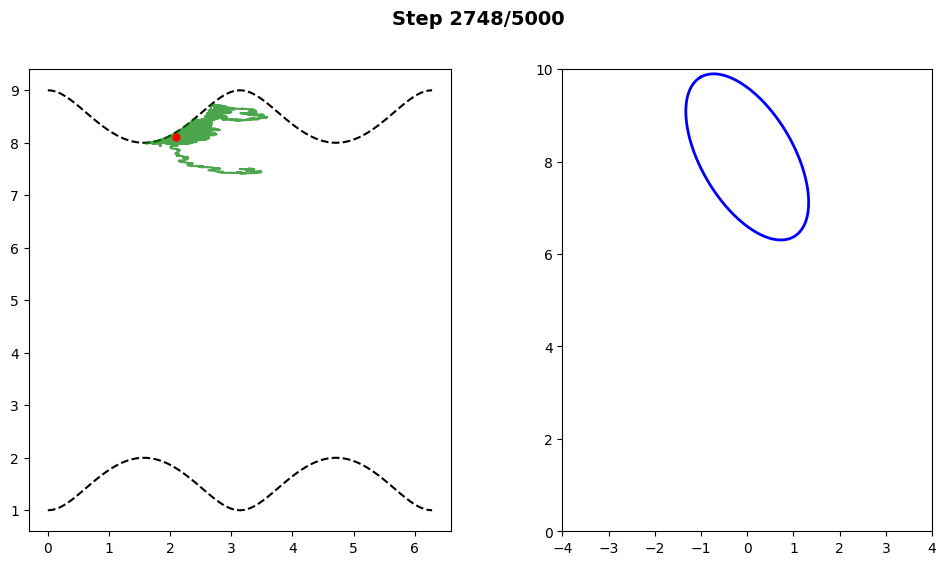

In [131]:
# For plotting a single trajectory to see how it's working out
from IPython.display import display, clear_output
import time

def build_oval(a, b, theta=0, y=0):
    """Generates the coordinates for an oval rotated by theta and shifted to height y."""
    t = np.linspace(0, 2 * np.pi, 360)
    x_coords = a * np.cos(t)  
    y_coords = b * np.sin(t) 

    # Apply rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    x_coords_rot = c * x_coords - s * y_coords
    y_coords_rot = s * x_coords + c * y_coords

    # Translate vertically to match y-position
    y_coords_rot += y  

    return x_coords_rot, y_coords_rot

def animate_trajectory_and_oval(trajectory, a=1, b=0.5, lower_bounds=None, upper_bounds=None, xlim=None, ylim=None, dt=0.05):

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    
    if xlim is None:
        xlim = (np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)
    
    ax1.set_xlim(*xlim)
    ax1.set_ylim(*ylim)
    ax2.set_xlim(-2*a, 2*a)  # Adjust horizontal limits based on oval size
    ax2.set_ylim(*ylim)

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax1.clear()
        ax2.clear()

        # Update oval plot bounds because it clears them every time
        ax2.set_xlim(-2*a, 2*a)
        ax2.set_ylim(*ylim)

        # Extract current values
        theta, y = trajectory[step_i]

        # Extract trajectory so far
        x_vals = trajectory[:step_i+1, 0]
        y_vals = trajectory[:step_i+1, 1]

        # Plot bounds on trajectory space
        if lower_bounds is not None:
            ax1.plot(lower_bounds[0], lower_bounds[1], 'k--', label="Lower Bound")
        
        if upper_bounds is not None:
            ax1.plot(upper_bounds[0], upper_bounds[1], 'k--', label="Upper Bound")

        # Plot the trajectory in (theta, y) space
        ax1.plot(x_vals, y_vals, 'g-', lw=1.5, alpha=0.7, label="Trajectory")  # Past trajectory
        ax1.plot(theta, y, 'ro', ms=5, label="Current Position")  # Moving point

        # Generate and plot the oval in real space
        oval_x, oval_y = build_oval(a, b, theta, y)
        ax2.plot(oval_x, oval_y, 'b-', lw=2, label="Oval")
        ax2.axhline(0, color='black', linestyle='--')  # Reference line

        # Set titles and labels
        ax1.set_title("Trajectory in (Theta, y) Space")
        ax1.set_xlabel("Theta")
        ax1.set_ylabel("y")
        ax1.legend()
        ax1.grid(True)

        ax2.set_title("Oval moving in channel")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")
        ax2.set_aspect('equal', 'box')
        # ax2.legend()
        ax2.grid(True)

        # title
        fig.suptitle(f"Step {step_i+1}/{len(trajectory)}", fontsize=14, fontweight='bold')

        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes

x_grid = np.linspace(0, W, 101)
animate_trajectory_and_oval(trajectory[:, :], a=a, b=b, lower_bounds=[x_grid, lower_bound(a, b, x_grid)],
                            upper_bounds=[x_grid, upper_bound(a, b, x_grid)], xlim=[-5, 5], ylim=[0,10],
                            dt=0.001)

In [177]:
# Following code can be used to simulate an oval with major and minor axes
# evolving with simple brownian motion

def find_intersection(p0, p1, boundary_function, a, b):
    # Define the quantities I'm going to need
    theta0, theta1 = p0[0], p1[0]
    dtheta = theta1 - theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(a, b, theta0 + t*dtheta) - (y0 + t*dy)
        return error
    
    try:
        solution = root_scalar(error, bracket=[0,1], method='bisect')

        if solution.converged:
            t_sol = solution.root
            theta_sol = theta0 + t_sol * dtheta
            y_sol = y0 + t_sol * dy
            collision_point = np.array([theta_sol, y_sol])
            return collision_point
        else:
            return None 
    except ValueError:
        return None  

def numerical_derivative(a, b, theta, func, h=1e-5):
    f_plus = func(a, b, theta + h)
    f_minus = func(a, b, theta - h)
    return (f_plus - f_minus)/(2*h)

def give_reflection(p_intersect, p1, boundary_func, a, b):

    theta_intersect = p_intersect[0]
    dy_dtheta = numerical_derivative(a, b, theta_intersect, boundary_func)[0]
    tangent = np.array([1, dy_dtheta]).reshape((2,1))
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot((p1 - p_intersect).T, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

def simulate(lower_bound_func, lower_bound_func_deriv, upper_bound_func, 
             upper_bound_func_deriv, X0=[0, 0.5], U=1, D_T=1e-3, D_R=0.1,
             dt=0.01, T=100, a=2, b=1):
    
    # setup simulation variables
    brownian_step = np.sqrt(2 * D_T * dt)
    brownian_r_step = np.sqrt(2 * D_R * dt)
    steps = int(T/dt)

    # Initialise the trajectory
    trajectory = np.zeros((steps, 2))
    trajectory[0, :] = X0

    for step in range(steps-1):
        # print(step)
        p_now = trajectory[step, :]
        theta_now = p_now[0]
        y_now = p_now[1]

        dy = U*np.sin(theta_now) * dt + brownian_step*np.random.randn(1)
        dtheta = brownian_r_step * np.random.randn(1)

        y_next = y_now + dy
        theta_next = theta_now + dtheta
        theta_next = theta_next % (2 * np.pi) # Reflective boundary conditions
        p_next = np.array([theta_next, y_next])
        
        if y_next - lower_bound_func(a, b, theta_next) < 0:
            print(f"Lower bound violted: {step}")
            p_intersect = find_intersection(p_now, p_next, lower_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, lower_bound_func_deriv, a, b)
            # p_reflect[1] += 0.01
            p_next = p_reflect

            # if find_intersection(p_now, p_next, lower_bound_func, a, b) is None:
            #     print("Let's examine some of these things")
            # print("lower bound violated", step)
            # p_intersect = find_intersection(p_now, p_next, lower_bound_func, a, b)
            # if p_intersect is None:
            #     print(f"Step {step}: Root finding failed, stopping simulation.")
            #     print(f"Problem points: {p_now, p_next}")
            #     trajectory[step + 1, :] = p_next.reshape(2,)
            #     return trajectory[:step + 2] 
            
            # p_reflect = give_reflection(p_intersect, p_next, lower_bound_func_deriv, a, b)
            # print(f"Lower Bound Reflected Point: {p_reflect}, p_now: {p_now}, boundary: {(p_reflect[1] - lower_bound(a, b, p_reflect[0])) > 0}")
            # p_next = p_reflect

        if y_next - upper_bound_func(a, b, theta_next) > 0:
            print(f"Step: {step}")
            p_intersect = find_intersection(p_now, p_next, upper_bound_func, a, b)
            p_reflect = give_reflection(p_intersect, p_next, upper_bound_func_deriv, a, b)
            # p_reflect -= 0.01
            p_now = p_intersect
            p_next = p_reflect
            # if find_intersection(p_now, p_next, upper_bound_func, a, b) is None:
            #     print("Let's examine some of these things")
            # print("upper bound violated", step)
            # p_intersect = find_intersection(p_now, p_next, upper_bound_func, a, b)
            # if p_intersect is None:
            #     print(f"Step {step}: Root finding failed, stopping simulation.")
            #     print(f"Problem points: {p_now, p_next}")
            #     trajectory[step + 1, :] = p_next.reshape(2,)
            #     return trajectory[:step + 2]  # Return valid part of trajectory
            
            # p_reflect = give_reflection(p_intersect, p_next, upper_bound_func_deriv, a, b)
            # print(f"Upper Bound Reflected Point: {p_reflect}, p_now: {p_now}, boundary: {(p_reflect[1] - upper_bound(a, b, p_reflect[0])) < 0}")
            # p_next = p_reflect
            

        
        
        trajectory[step + 1, :] = p_next.reshape(2,)
    return trajectory

trajectory = simulate(lower_bound_func=lower_bound, lower_bound_func_deriv=lower_bound_deriv,
                      upper_bound_func=upper_bound, upper_bound_func_deriv=upper_bound_deriv,
                      X0=[theta0, 8.5], a=a, b=b, dt=0.01, T=50)

Lower bound violted: 1464
Lower bound violted: 1469
Lower bound violted: 1481
Lower bound violted: 1486
Lower bound violted: 1487
Lower bound violted: 1496
Lower bound violted: 1499
Lower bound violted: 1513
Lower bound violted: 1515
Lower bound violted: 1516
Lower bound violted: 1518
Lower bound violted: 1535
Lower bound violted: 1573
Lower bound violted: 1576
Lower bound violted: 1582
Lower bound violted: 1591
Lower bound violted: 1600
Lower bound violted: 1602
Lower bound violted: 1607
Lower bound violted: 1610
Lower bound violted: 1613
Lower bound violted: 1614
Lower bound violted: 1666
Lower bound violted: 1688
Lower bound violted: 1689
Lower bound violted: 1746
Lower bound violted: 1775
Lower bound violted: 1818
Lower bound violted: 1834
Lower bound violted: 1839
Lower bound violted: 1852
Lower bound violted: 1860
Lower bound violted: 1862
Lower bound violted: 1870
Lower bound violted: 1881
Lower bound violted: 1883
Lower bound violted: 1884
Lower bound violted: 2000
Lower bound 

TypeError: 'NoneType' object is not subscriptable

KeyboardInterrupt: 

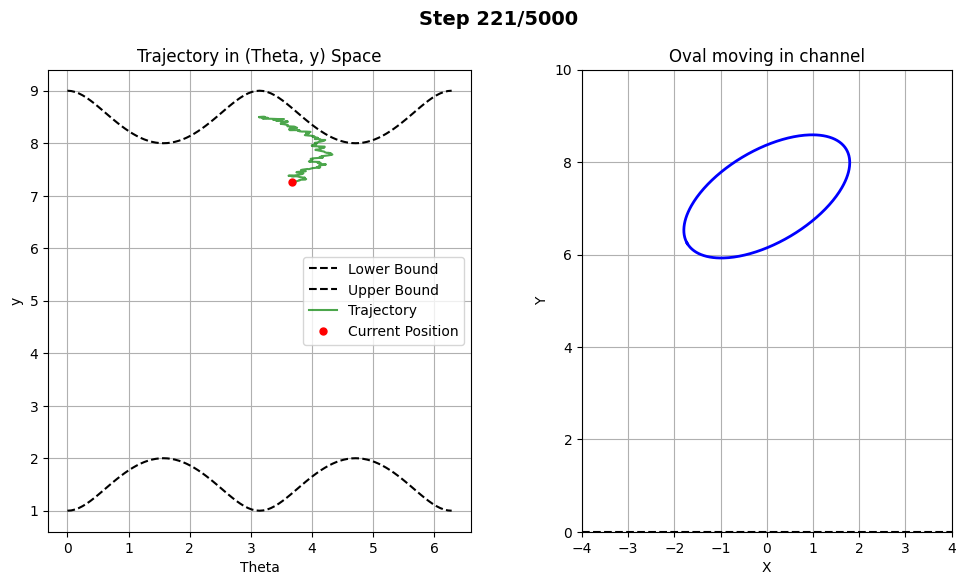

In [117]:
animate_trajectory_and_oval(trajectory, a=a, b=b, lower_bounds=[x_grid, lower_bound(a, b, x_grid)],
                            upper_bounds=[x_grid, upper_bound(a, b, x_grid)], xlim=[-5, 5], ylim=[0,10],
                            dt=0.1)

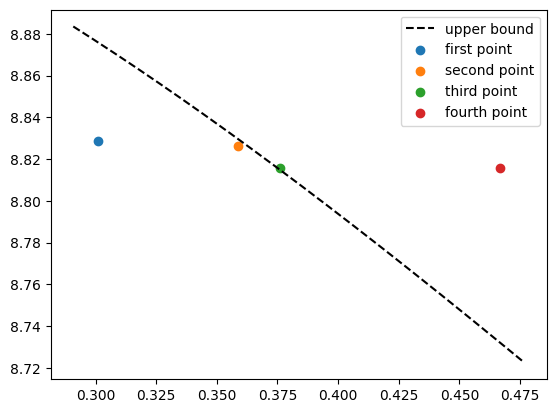

In [91]:
problem_points = trajectory[5977:, :]
theta_grid = np.linspace(min(problem_points[:, 0])-0.01, max(problem_points[:, 0])+0.01, 301)
# plt.plot(theta_grid, lower_bound(a, b, theta_grid), color='black', linestyle='--', label='lower bound')
plt.plot(theta_grid, upper_bound(a, b, theta_grid), color='black', linestyle='--', label='upper bound')
plt.scatter(problem_points[0, 0], problem_points[0, 1], label='first point')
plt.scatter(problem_points[1, 0], problem_points[1, 1], label='second point')
plt.scatter(problem_points[2, 0], problem_points[2, 1], label='third point')
plt.scatter(problem_points[3, 0], problem_points[3, 1], label='fourth point')
# plt.scatter(problem_points[4, 0], problem_points[4, 1], label='fifth point')
# plt.scatter(problem_points[5, 0], problem_points[5, 1], label='sixth point')
# plt.hlines(8.27, xmin=0.82, xmax=0.97, linestyle='--')

plt.legend()


In [68]:
# Problem points: (array([0.9491928 , 8.27346138]), array([[0.96163842],
#        [8.28218546]]))
p_now = problem_points[-2, :]
print(p_now)
print(p_now[1] - upper_bound(a, b, p_now[0]))
p_next = problem_points[-1, :]
print(p_next)
print(p_next[1] - upper_bound(a, b, p_next[0]))

[0.9491928  8.27346138]
0.0004941343727082881
[0.96163842 8.28218546]
0.01937869006480497


-0.0006222980730523631


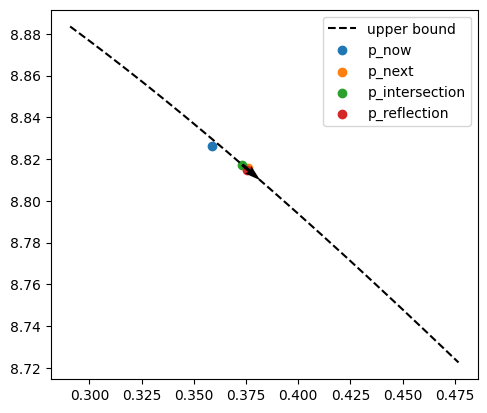

In [174]:
def find_intersection(p0, p1, boundary_function, a, b):
    # Define the quantities I'm going to need
    theta0, theta1 = p0[0], p1[0]
    dtheta = theta1 - theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(a, b, theta0 + t*dtheta) - (y0 + t*dy)
        return error
    
    try:
        solution = root_scalar(error, bracket=[0,1], method='bisect')

        if solution.converged:
            t_sol = solution.root
            theta_sol = theta0 + t_sol * dtheta
            y_sol = y0 + t_sol * dy
            collision_point = np.array([theta_sol, y_sol])
            return collision_point
        else:
            return None 
    except ValueError:
        return None
    
def numerical_derivative(a, b, theta, func, h=1e-5):
    f_plus = func(a, b, theta + h)
    f_minus = func(a, b, theta - h)
    return (f_plus - f_minus)/(2*h)

def give_reflection(p_intersect, p1, boundary_func, a, b):

    theta_intersect = p_intersect[0]
    dy_dtheta = numerical_derivative(a, b, theta_intersect, boundary_func)
    tangent = np.array([1, dy_dtheta])
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot((p1 - p_intersect).T, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

oval_vert_dist = lambda a, b, theta: abs(np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2))
lower_bound = lambda a, b, theta: 0 + oval_vert_dist(a, b, theta)
upper_bound = lambda a, b, theta: H - oval_vert_dist(a, b, theta)
lower_bound_deriv = lambda a, b, theta: (np.cos(theta)*np.sin(theta)*(b**2 - a**2))/ \
    (np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2))
upper_bound_deriv = lambda a, b, theta: lower_bound_deriv(a, b, theta) * -1

p_now = problem_points[-3, :]
p_next = problem_points[-2, :]
p_intersection = find_intersection(p_now, p_next, upper_bound, a, b)
p_reflection = give_reflection(p_intersection, p_next, upper_bound, a, b)

theta_grid = np.linspace(min(problem_points[:, 0])-0.01, max(problem_points[:, 0])+0.01, 301)
# plt.plot(theta_grid, lower_bound(a, b, theta_grid), color='black', linestyle='--', label='lower bound')
fig, ax = plt.subplots()
ax.plot(theta_grid, upper_bound(a, b, theta_grid), color='black', linestyle='--', label='upper bound')
ax.scatter(p_now[0], p_now[1], label='p_now')
ax.scatter(p_next[0], p_next[1], label='p_next')
ax.scatter(p_intersection[0], p_intersection[1], label='p_intersection')
ax.scatter(p_reflection[0], p_reflection[1], label='p_reflection')
ax.quiver(p_intersection[0], p_intersection[1], 1, numerical_derivative(a, b, p_intersection[0], upper_bound))
ax.legend()
ax.set_aspect('equal')

print(p_reflection[1] - upper_bound(a, b, p_reflection[0]))


In [104]:
# Next case, consider on the lower bound


[0.37595554 8.81554637] [0.37617989 8.81596439]


In [105]:
p_reflection - upper_bound(a, b, p_reflection[0])

array([-8.43854270e+00,  1.24179213e-03])